#### authors: Rafael Dousse, Eva Ray, Massimo Stefani

# Practical work 08 - Clustering

## Imports

In [1]:
import _pickle as pickle
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

## Exercise 1 - Getting the data

a) Load the two given datasets:

In [2]:
data1, label1 = pickle.load(open("dataset_1.pkl", "rb"), encoding ="latin1")
data2, label2 = pickle.load(open("dataset_2.pkl", "rb"), encoding ="latin1")

In [8]:
label2

array([1, 1, 3, ..., 3, 2, 1], shape=(3000,))

b) Visualize the data using various color for each unique labels

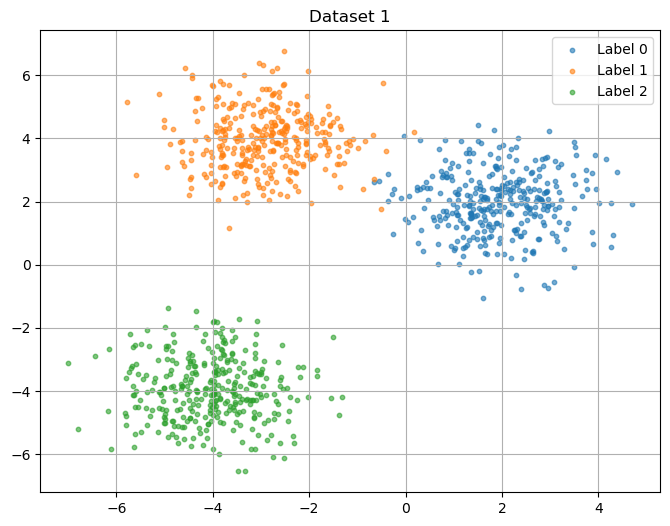

In [15]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(label1)
for lbl in unique_labels:
    plt.scatter(data1[label1 == lbl, 0], data1[label1 == lbl, 1], label=f'Label {lbl}', s=10, alpha=0.6)
plt.title('Dataset 1')
plt.grid()
plt.legend()
plt.show()

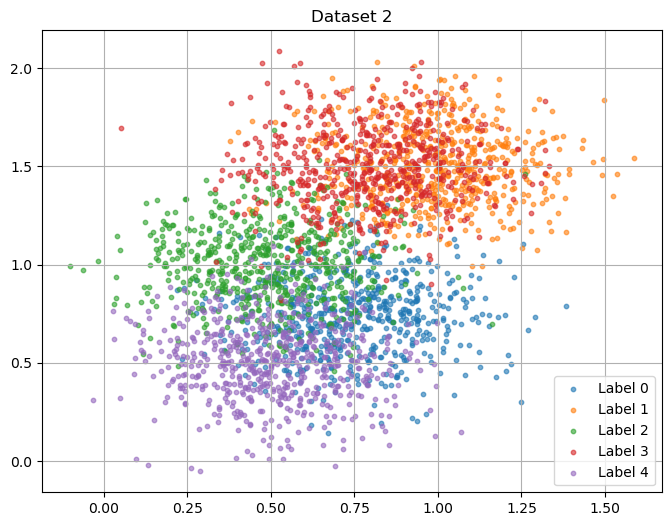

In [16]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(label2)
for lbl in unique_labels:
    plt.scatter(data2[label2 == lbl, 0], data2[label2 == lbl, 1], label=f'Label {lbl}', s=10, alpha=0.6)
plt.title('Dataset 2')
plt.grid()
plt.legend()
plt.show()

## Exercise 2 - The $k$-means algorithm

a) Initialise the centroids $\mu_1, \mu_2, ... , \mu_K$

In [35]:
def initialise_centroids(data, k, seed=13):
    """
    Initialise k centroids by randomly selecting k unique samples from the data.
    Parameters:
        - data: numpy array of shape (n_samples, n_features)
        - k: number of centroids
        - seed: random seed for reproducibility
    Returns:
        - centroids: numpy array of shape (k, n_features)
    """
    np.random.seed(seed)
    nb_samples = data.shape[0]
    return data[np.random.choice(nb_samples, k, replace=False)]

b) Until convergence :

<span style="margin-left: 20px;">i) Find the closest centroid for each point</span>

In [30]:
# We choose to use the Euclidean distance
def find_closest_centroids(data, codebook):
    """"
    Find the index of the closest centroid for each sample in the data.
    Parameters:
        - data: numpy array of shape (n_samples, n_features)
        - codebook: numpy array of shape (k, n_features) representing the centroids
    Returns:
        - closest_centroids: numpy array of shape (n_samples,) representing the index of the closest centroid for each sample
    """
    distances = []
    for sample in data:
        # linalg.norm computes the norm of a vector, here we compute the norm between the sample and each centroid, which
        # gives us the euclidean distance
        sample_distances = [np.linalg.norm(sample - centroid) for centroid in codebook]
        distances.append(sample_distances)
    return np.argmin(distances, axis=1)


<span style="margin-left: 20px;">ii) Reevaluate the centroids</span>

In [33]:
def reevaluate_centroids(data, closest_centroids, k):
    """"
    Reevaluate the centroids by computing the mean of all samples assigned to each centroid.
    Parameters:
        - data: numpy array of shape (n_samples, n_features)
        - closest_centroids: numpy array of shape (n_samples,) representing the index of the closest centroid for each sample
        - k: number of centroids
    Returns:
        - new_codebook: numpy array of shape (k, n_features) representing the new centroids
    """
    new_codebook = []
    for i in range(k):
        # We take the mean of all the points assigned to the centroid i
        points_assigned = data[closest_centroids == i]
        new_centroid = np.mean(points_assigned, axis=0)
        new_codebook.append(new_centroid)
    return np.array(new_codebook)

c) Return the $k$ centroids.

In [38]:
def kmeans_algorithm(data, k, max_epochs=1000, tol=1e-4, seed=13):
    """"
    Runs the k-means algorithm on the given data.
    Parameters:
        - data: numpy array of shape (n_samples, n_features)
        - k: number of clusters
        - max_epochs: maximum number of iterations
        - tol: tolerance for convergence
    Returns:
        - codebook: numpy array of shape (k, n_features) representing the centroids
        - closest_centroids: numpy array of shape (n_samples,) representing the index of the
            closest centroid for each sample
        - convergence_criteria: list of convergence criteria over epochs
    """
    codebook = initialise_centroids(data, k, seed)
    convergence_criteria = []

    for epoch in range(max_epochs):
        closest_centroids = find_closest_centroids(data, codebook)
        new_codebook = reevaluate_centroids(data, closest_centroids, k)

        # Compute convergence criteria
        change = np.linalg.norm(new_codebook - codebook)
        convergence_criteria.append(change)

        # if the change is less than the tolerance, we consider that we have converged
        if change < tol:
            break

        codebook = new_codebook

    return codebook, closest_centroids, convergence_criteria

We also ask you to define and implement strategies for the :

* Initialisation of the centroids.
* Convergence criteria.

- Initialisation of the centroids: We use random initialization by selecting k random samples from the dataset as the initial centroids. This is done using the `initialise_centroids` function, which ensures that the selected centroids are unique by using `replace=False` in `np.random.choice`.
- Convergence criteria: We use the change in centroids' positions as the convergence criteria. If the change is less than a specified tolerance (tol), we consider that the algorithm has converged.

We saw that the k-means algorithm can converge to a local minimum depending on the initialisation of the centroids. One way to mitigate this problem is to run the algorithm multiple times with different initialisations and select the clustering that gives the lowest distortion. This strategy is implemented below.

In [39]:
def calculate_distortion(data, codebook, closest_centroids):
    """
    Compute the distortion J (sum of squared distances between each point and its centroid)
    """
    total_distortion = 0
    for i in range(len(data)):
        centroid = codebook[closest_centroids[i]]
        total_distortion += np.sum((data[i] - centroid) ** 2)
    return total_distortion

def kmeans_algorithm_multiple_runs(data, k, n_runs=10, max_epochs=1000, tol=1e-4):
    """
    Runs the k-means algorithm multiple times and keeps the best result
    """
    best_distortion = float('inf')
    best_codebook = None
    best_closest_centroids = None
    best_convergence = None

    for run in range(n_runs):
        # Runs k-means with a different random seed
        seed = np.random.randint(0, 1000)
        codebook, closest_centroids, convergence = kmeans_algorithm(data, k, max_epochs, tol, seed)

        # Compute distortion
        distortion = calculate_distortion(data, codebook, closest_centroids)

        # Update best result if current distortion is lower
        if distortion < best_distortion:
            best_distortion = distortion
            best_codebook = codebook
            best_closest_centroids = closest_centroids
            best_convergence = convergence

    return best_codebook, best_closest_centroids, best_convergence, best_distortion

## Exercise 3 - Evaluate your model

Run your algorithm with the dataset 1.

In [8]:
# Your code here

Visualize your convergence criteria over the epochs using the dataset 1.

In [9]:
# Your code here

Visualize the output of your $k$-means on the dataset 1.

In [10]:
# Your code here

Do you experience sensitivity to the initial values of the centroids? Is your strategy for initialization working well in most cases?

_Your answer here_

Document your convergence criteria. Could you think about other convergence criteria?

_Your answer here_

Run your algorithm with the dataset 2.

In [11]:
# Your code here

Visualize your convergence criteria over time using the dataset 2.

In [12]:
# Your code here

Visualize the output of your $k$-means on the dataset 2 and comment your results.

In [13]:
# Your code here

_Your comment_